In [ ]:
import pandas as pd

# Leer el archivo CSV (separado por comas)
df = pd.read_csv('limpio.csv')

# Vista previa del DataFrame
df.head()

,Fecha (GMT),AlturaSignif.delOleaje(m),PeriodoMedio(s),Periodo_Pico,Direccion_Procedencia,Mardefondo1:Alturasignif.Espectral(m),Velocidad media de Corriente(m/s),"Dir. de prop. de la Corriente (0=N,90=E)",SOLAR PRESENCE,LUNAR PRESENCE,...,MN_Illu%,PsAng,PsAMV,Sky_motion,Sky_mot_PA,RelVel-ANG,Salinidad(psu),Temperatura del Agua(ºC),Velocidad del viento(m/s),"Direc. de proced. del Viento(0=N,90=E)"
0,2019-12-12 00:00:00,2.09,10.4,14.7,352.0,1.86,0.074,92.57,,m,...,99.9060,43.944,264.350,22.905428,74.381959,-4.531192,34.979,14.506,7.33,262.0
1,2019-12-12 01:00:00,2.16,11.2,14.7,353.0,1.94,0.067,92.53,,m,...,99.9207,41.045,264.487,22.947002,77.164054,1.803459,34.979,14.500,5.82,243.0
2,2019-12-12 02:00:00,2.23,11.4,14.7,353.0,2.01,0.063,92.42,,m,...,99.9334,37.211,264.630,23.724617,80.111940,7.457271,34.979,14.492,5.84,253.0
3,2019-12-12 03:00:00,2.27,11.3,14.7,353.0,2.04,0.060,92.21,,m,...,99.9442,32.059,264.783,25.186602,82.794879,11.610805,34.979,14.484,5.61,252.0
4,2019-12-12 04:00:00,2.28,11.5,14.7,353.0,2.06,0.058,91.96,,m,...,99.9530,25.130,264.949,27.216201,84.925967,14.023396,34.979,14.475,5.36,236.0


In [ ]:
# Convertir la columna de fecha a datetime y establecer como índice
df['Fecha (GMT)'] = pd.to_datetime(df['Fecha (GMT)'])
df.set_index('Fecha (GMT)', inplace=True)
# Establecemos la frecuencia
df = df.asfreq('h')

# Asegurarse de que los datos estén ordenados por fecha
df.sort_index(inplace=True)

# Seleccionar la serie a modelar
serie = df['AlturaSignif.delOleaje(m)']

# **2 AÑOS**

In [ ]:
import pandas as pd

# Obtener fecha inicial
fecha_inicio = df.index.min()

# Definir duración del entrenamiento y prueba
train_duracion = pd.DateOffset(months=24)               # 2 años de entrenamiento
test_duracion = pd.DateOffset(months=6)                 # 6 meses de prueba

# Calcular fechas de corte
fecha_corte_train = fecha_inicio + train_duracion
fecha_corte_test = fecha_corte_train + test_duracion

# Serie objetivo
serie = df['AlturaSignif.delOleaje(m)']

# División temporal
serie_entrenamiento = serie.loc[fecha_inicio : fecha_corte_train - pd.Timedelta(hours=1)]
serie_prueba = serie.loc[fecha_corte_train : fecha_corte_test - pd.Timedelta(hours=1)]

In [ ]:
exog_cols = ['Mardefondo1:Alturasignif.Espectral(m)', 'PeriodoMedio(s)']

exog_entrenamiento = df[exog_cols].loc[serie_entrenamiento.index]
exog_prueba = df[exog_cols].loc[serie_prueba.index]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

orden = (3, 0, 3)

modelo_arimax = ARIMA(
    serie_entrenamiento,
    order=orden,
    exog=exog_entrenamiento
).fit()

n_pred = len(serie_prueba)

predicciones_arimax = modelo_arimax.predict(
    start=len(serie_entrenamiento),
    end=len(serie_entrenamiento) + n_pred - 1,
    exog=exog_prueba
)

reales_arimax = serie_prueba[:len(predicciones_arimax)]

# Evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(reales_arimax, predicciones_arimax)
rmse = np.sqrt(mse)
r2_2A = r2_score(reales_arimax, predicciones_arimax)
mae = mean_absolute_error(reales_arimax, predicciones_arimax)
mape = np.mean(np.abs((reales_arimax - predicciones_arimax) / reales_arimax)) * 100

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE : 0.0364
RMSE: 0.1909
R²  : 0.9205
MAE : 0.1389
MAPE: 21.35%


# **1 año**

In [ ]:
# Obtener fecha inicial
fecha_inicio = df.index.min()

# Definir duración del entrenamiento y prueba
train_duracion = pd.DateOffset(months=12)  # 12 meses para train
test_duracion = pd.DateOffset(months=3)    # 3 meses para test (mantiene proporción 80/20)

# Calcular fechas de corte
fecha_corte_train = fecha_inicio + train_duracion
fecha_corte_test = fecha_corte_train + test_duracion

# Serie objetivo
serie = df['AlturaSignif.delOleaje(m)']

# División temporal
serie_entrenamiento = serie.loc[fecha_inicio : fecha_corte_train - pd.Timedelta(hours=1)]
serie_prueba = serie.loc[fecha_corte_train : fecha_corte_test - pd.Timedelta(hours=1)]

In [ ]:
exog_cols = ['Mardefondo1:Alturasignif.Espectral(m)', 'PeriodoMedio(s)']

exog_entrenamiento = df[exog_cols].loc[serie_entrenamiento.index]
exog_prueba = df[exog_cols].loc[serie_prueba.index]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

orden = (3, 0, 3)

modelo_arimax = ARIMA(
    serie_entrenamiento,
    order=orden,
    exog=exog_entrenamiento
).fit()

n_pred = len(serie_prueba)

predicciones_arimax = modelo_arimax.predict(
    start=len(serie_entrenamiento),
    end=len(serie_entrenamiento) + n_pred - 1,
    exog=exog_prueba
)

reales_arimax = serie_prueba[:len(predicciones_arimax)]

# Evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(reales_arimax, predicciones_arimax)
rmse = np.sqrt(mse)
r2 = r2_score(reales_arimax, predicciones_arimax)
mae = mean_absolute_error(reales_arimax, predicciones_arimax)
mape = np.mean(np.abs((reales_arimax - predicciones_arimax) / reales_arimax)) * 100

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


MSE : 0.0547
RMSE: 0.2339
R²  : 0.9006
MAE : 0.1599
MAPE: 18.79%


# **6 meses**

In [ ]:
# Obtener fecha inicial
fecha_inicio = df.index.min()

# Definir duración total del bloque: 6 meses (train) + 1.5 meses (test)
train_duracion = pd.DateOffset(months=6)
test_duracion = pd.DateOffset(days=int(6 * 0.20 * 30))  # Aproximadamente 1.5 meses = 45 días

# Fecha de corte de entrenamiento y prueba
fecha_corte_train = fecha_inicio + train_duracion
fecha_corte_test = fecha_corte_train + test_duracion

# Serie objetivo
serie = df['AlturaSignif.delOleaje(m)']

# División temporal
serie_entrenamiento = serie.loc[fecha_inicio : fecha_corte_train - pd.Timedelta(hours=1)]
serie_prueba = serie.loc[fecha_corte_train : fecha_corte_test - pd.Timedelta(hours=1)]

In [ ]:
exog_cols = ['Mardefondo1:Alturasignif.Espectral(m)', 'PeriodoMedio(s)']

exog_entrenamiento = df[exog_cols].loc[serie_entrenamiento.index]
exog_prueba = df[exog_cols].loc[serie_prueba.index]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

orden = (3, 0, 3)
modelo_arimax = ARIMA(
    serie_entrenamiento,
    order=orden,
    exog=exog_entrenamiento
).fit()

n_pred = len(serie_prueba)

predicciones_arimax = modelo_arimax.predict(
    start=len(serie_entrenamiento),
    end=len(serie_entrenamiento) + n_pred - 1,
    exog=exog_prueba
)

reales_arimax = serie_prueba[:len(predicciones_arimax)]

# Evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(reales_arimax, predicciones_arimax)
rmse = np.sqrt(mse)
r2 = r2_score(reales_arimax, predicciones_arimax)
mae = mean_absolute_error(reales_arimax, predicciones_arimax)
mape = np.mean(np.abs((reales_arimax - predicciones_arimax) / reales_arimax)) * 100

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.2f}%")




/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE : 0.0249
RMSE: 0.1579
R²  : 0.4200
MAE : 0.1076
MAPE: 20.82%


# **3 MESES**

In [ ]:
# Obtener fecha inicial
fecha_inicio = df.index.min()

# Definir duración del entrenamiento y prueba
train_duracion = pd.DateOffset(months=3)                  # 3 meses de entrenamiento
test_duracion = pd.DateOffset(days=int(30 * 0.75))        # 0.75 meses ≈ 22.5 días

# Calcular fechas de corte
fecha_corte_train = fecha_inicio + train_duracion
fecha_corte_test = fecha_corte_train + test_duracion

# Serie objetivo
serie = df['AlturaSignif.delOleaje(m)']

# División temporal
serie_entrenamiento = serie.loc[fecha_inicio : fecha_corte_train - pd.Timedelta(hours=1)]
serie_prueba = serie.loc[fecha_corte_train : fecha_corte_test - pd.Timedelta(hours=1)]

In [ ]:
exog_cols = ['Mardefondo1:Alturasignif.Espectral(m)', 'PeriodoMedio(s)']

exog_entrenamiento = df[exog_cols].loc[serie_entrenamiento.index]
exog_prueba = df[exog_cols].loc[serie_prueba.index]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

orden = (3, 0, 3)

modelo_arimax = ARIMA(
    serie_entrenamiento,
    order=orden,
    exog=exog_entrenamiento
).fit()

n_pred = len(serie_prueba)

predicciones_arimax = modelo_arimax.predict(
    start=len(serie_entrenamiento),
    end=len(serie_entrenamiento) + n_pred - 1,
    exog=exog_prueba
)

reales_arimax = serie_prueba[:len(predicciones_arimax)]

# Evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(reales_arimax, predicciones_arimax)
rmse = np.sqrt(mse)
r2 = r2_score(reales_arimax, predicciones_arimax)
mae = mean_absolute_error(reales_arimax, predicciones_arimax)
mape = np.mean(np.abs((reales_arimax - predicciones_arimax) / reales_arimax)) * 100

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.2f}%")



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE : 0.0993
RMSE: 0.3151
R²  : 0.4706
MAE : 0.1941
MAPE: 17.79%


# **Grafico visualización**

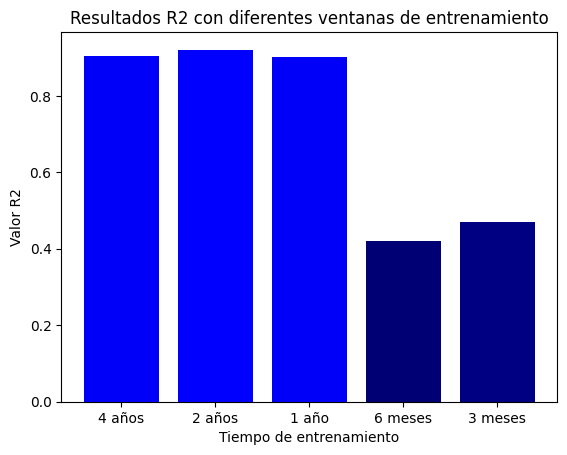

In [2]:
import matplotlib.pyplot as plt

#  valores manuales
valores = [0.9028, 0.9205, 0.9006, 0.4200, 0.4706]

#  etiquetas personalizadas para cada barra
etiquetas = ['4 años', '2 años', '1 año', '6 meses', '3 meses']

# Crear colores en tonos de azul según la altura
max_val = max(valores)
colores = [(0, 0, valor/max_val) for valor in valores]  # RGB con componente azul proporcional

# Crear el gráfico de barras
plt.bar(etiquetas, valores, color=colores)
plt.title('Resultados R2 con diferentes ventanas de entrenamiento')
plt.xlabel('Tiempo de entrenamiento')
plt.ylabel('Valor R2')
plt.show()
